# System for films Recomendation  (IMDB)

### OBJ: To Define the best model and hyperparam for a System Recomendation


## 0-1. Libraries

In [1]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 

## 0-2. Functions

*  getting data

In [2]:
def read_ratings_matrix(file):

    ratings = [[None for _ in range(NUM_ITEMS)] for _ in range(NUM_USERS)] 
    
    with open(file, 'r') as reader:
        for line in reader:
            [u, i, rating] = line.split("::")
            ratings[int(u)][int(i)] = int(rating)
            
    return ratings

*  Similarity matrix

In [3]:
def calculate_similarities(ratings_matrix, similarity_metric):
    
    # Creamos una matriz con valores de similaridad a -1
    similarities = [[float('-inf') for _ in range(NUM_USERS)] for _ in range(NUM_USERS)]
    
    # Recorremos la matriz por usuario
    for i, u in enumerate(ratings_matrix):
        if i%100==0:
            print("\tProcesandos {} Usuarios".format(i))
        for j, v in enumerate(ratings_matrix):
            if j != i: # No calculamos la similaridad para un mismo usuario
                similarities[i][j] = similarity_metric(u,v)
        
    return similarities

*  Similarity functions

In [4]:



def rating_average(ratings):
    
    acc = 0
    count = 0
    for id_item in range(len(ratings)):
        if ratings[id_item] != None:
            acc += ratings[id_item]
            count += 1
    return acc / count


def msd_similarity(u, v):
    
    sum_r = 0 
    count = 0
    
    for i in range(len(u)):
        if u[i] != None and v[i] != None:
            count += 1
            sum_r += math.pow((u[i] - v[i])/(MAX_RATING - MIN_RATING), 2)
            
    if count > 0:
        sim = 1-(sum_r/float(count))
        return sim
    else:
        return None
    
    
def cosine_similarity(u, v):
    
    numerador = 0
    denominador_u = 0
    denominador_v = 0
    
    count = 0
    
    for i in range(len(u)):
        if u[i] != None and v[i] != None:
            numerador += u[i] * v[i]
            denominador_u += math.pow(u[i], 2)
            denominador_v += math.pow(v[i], 2)
            count += 1
    if count > 0 and denominador_u != 0 and denominador_v != 0:
        cos = numerador / (math.sqrt(denominador_u) * math.sqrt(denominador_v))
        return cos
    else:
        return None
    
    
def jmsd_similarity(u, v):
    
    union = 0
    intersection = 0
    
    for i in range(len(u)):
        if u[i] != None and v[i] != None:
            intersection += 1
            union += 1
        elif u[i] != None or v[i] != None:  
            union += 1
            
    if intersection > 0:
        jaccard = intersection / union
        return jaccard * msd_similarity(u,v)
    else:
        return None


* Similars Neighbors

In [5]:
def calculate_neighbors(similarities_matrix, k_neighbors):
    
    neighbors = [None for _ in range(NUM_USERS)]
    
    for index, similarities in enumerate(similarities_matrix):
        i_neighbors = [i[0] for i in sorted(enumerate(similarities), 
                                            key=lambda x:float('-inf') if x[1] is None else x[1], 
                                            reverse=True)]
        neighbors[index] = i_neighbors[0:k_neighbors]

    return neighbors

* Predictions

In [6]:

    
def calculate_weighted_average_prediction(ratings_matrix, similarities_matrix, neighbors):
    
    # Creamos una matriz para el cálculo de predicciones
    predictions = [[None for _ in range(NUM_ITEMS)] for _ in range(NUM_USERS)]
    
    # Recorremos la matriz de votos
    for i, u in enumerate(ratings_matrix):
        for j, v in enumerate(ratings_matrix[0]):
            # Obtenemos las similaridades con cada vecino y si voto
            numerador = 0 
            denominador = 0
            for neighbor in neighbors[i]:
                if ratings_matrix[neighbor][j] != None:
                    numerador += similarities_matrix[i][neighbor] * ratings_matrix[neighbor][j]
                    denominador += similarities_matrix[i][neighbor]
                    
            predictions[i][j] = None if denominador == 0 else numerador/denominador
            
    return predictions

def calculate_weighted_average_prediction(ratings_matrix, similarities_matrix, neighbors):
    
    # Creamos una matriz para el cálculo de predicciones
    predictions = [[None for _ in range(NUM_ITEMS)] for _ in range(NUM_USERS)]
    
    # Recorremos la matriz de votos
    for i, u in enumerate(ratings_matrix):
        for j, v in enumerate(ratings_matrix[0]):
            # Obtenemos las similaridades con cada vecino y si voto
            numerador = 0 
            denominador = 0
            for neighbor in neighbors[i]:
                if ratings_matrix[neighbor][j] != None:
                    numerador += similarities_matrix[i][neighbor] * ratings_matrix[neighbor][j]
                    denominador += similarities_matrix[i][neighbor]
                    
            predictions[i][j] = None if denominador == 0 else numerador/denominador
            
    return predictions



def calculate_average_prediction(ratings_matrix, neighbors):
    
    # Creamos una matriz para el cálculo de predicciones
    predictions = [[None for _ in range(NUM_ITEMS)] for _ in range(NUM_USERS)]
    
    # Recorremos la matriz de votos
    for i, u in enumerate(ratings_matrix):
        for j, v in enumerate(ratings_matrix[0]):

            # Obtenemos las votaciones de cada vecino y calculamos el voto medio
            sum_r = 0 
            count = 0
            for neighbor in neighbors[i]:
                if ratings_matrix[neighbor][j] != None:
                    count += 1
                    sum_r += ratings_matrix[neighbor][j]
                    
            predictions[i][j] = None if count == 0 else sum_r/count
            
    return predictions

* Recomendations

In [7]:

def get_mae(ratings_matrix, predictions_matrix):
    
    mae_users = [None for _ in ratings_matrix]
    
    # Recorremos la matriz de votos
    for i, u in enumerate(ratings_matrix):
        # Calculamos el MAE de cada usuario
        sum_user = 0
        count = 0
        for j, v in enumerate(ratings_matrix[0]):
            if ratings_matrix[i][j] != None and predictions_matrix[i][j] != None:
                sum_user += abs(ratings_matrix[i][j] - predictions_matrix[i][j])
                count += 1
        mae_users[i] = sum_user/count if count > 0 else None

    return np.nanmean(np.array(mae_users, dtype=np.float), axis=0)

In [8]:
# Evaluation 

def get_mae(ratings_matrix, predictions_matrix):
    
    mae_users = [None for _ in ratings_matrix]
    
    # Recorremos la matriz de votos
    for i, u in enumerate(ratings_matrix):
        # Calculamos el MAE de cada usuario
        sum_user = 0
        count = 0
        for j, v in enumerate(ratings_matrix[0]):
            if ratings_matrix[i][j] != None and predictions_matrix[i][j] != None:
                sum_user += abs(ratings_matrix[i][j] - predictions_matrix[i][j])
                count += 1
        mae_users[i] = sum_user/count if count > 0 else None

    return np.nanmean(np.array(mae_users, dtype=np.float), axis=0)

<hr>



### 1.- Get Data

In [9]:
train_data_url='./Datos/movielens_100K_train_test/movielens_100k_training.txt'
test_data_url='./Datos/movielens_100K_train_test/movielens_100k_test.txt'
train_data=pd.read_csv(train_data_url, sep='::',engine='python')
test_data=pd.read_csv(test_data_url,sep='::',engine='python')

In [10]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95831 entries, 0 to 95830
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   0       95831 non-null  int64
 1   0.1     95831 non-null  int64
 2   5       95831 non-null  int64
dtypes: int64(3)
memory usage: 2.2 MB


In [11]:
for i in range(0,3):
    print('columna:',train_data.columns[i],'numeros de categorias:',train_data.iloc[:,i].nunique())

columna: 0 numeros de categorias: 943
columna: 0.1 numeros de categorias: 1670
columna: 5 numeros de categorias: 5


This data set consists of:
* 100,000 ratings (1-5) from 943 users on 1682 movies.
* Each user has rated at least 20 movies.

https://www.kaggle.com/prajitdatta/movielens-100k-dataset

In [12]:
NUM_USERS = 943
NUM_ITEMS = 1682
MIN_RATING=min(train_data['5'].unique())
MAX_RATING=max(train_data['5'].unique())



### 2. RATING MATRIX

In [13]:
rating_matrix_train=read_ratings_matrix(file=train_data_url)
rating_matrix_test=read_ratings_matrix(file=test_data_url)

# rating matrix
pd.DataFrame(data=np.array([np.array(xi) for xi in rating_matrix_train]),
             index=["U{}".format(str(i)) for i in range(NUM_USERS)],
             columns=["I{}".format(str(i)) for i in range(NUM_ITEMS)])

,I0,I1,I2,I3,I4,I5,I6,I7,I8,I9,...,I1672,I1673,I1674,I1675,I1676,I1677,I1678,I1679,I1680,I1681
U0,5,3,4,3,3,5,4,1,5,3,...,None,None,None,None,None,None,None,None,None,None
U1,4,None,None,None,None,None,None,None,None,2,...,None,None,None,None,None,None,None,None,None,None
U2,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
U3,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
U4,4,3,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U938,None,None,None,None,None,None,None,None,5,None,...,None,None,None,None,None,None,None,None,None,None
U939,None,None,None,2,None,None,None,None,3,None,...,None,None,None,None,None,None,None,None,None,None
U940,5,None,None,None,None,None,4,None,None,None,...,None,None,None,None,None,None,None,None,None,None
U941,None,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


### 3.- Similarity matrix

In [14]:
# using JMSD
similarities_matrix = calculate_similarities(ratings_matrix=rating_matrix_train, 
                                                 similarity_metric=jmsd_similarity)

	Procesandos 0 Usuarios
	Procesandos 100 Usuarios
	Procesandos 200 Usuarios
	Procesandos 300 Usuarios
	Procesandos 400 Usuarios
	Procesandos 500 Usuarios
	Procesandos 600 Usuarios
	Procesandos 700 Usuarios
	Procesandos 800 Usuarios
	Procesandos 900 Usuarios


In [15]:
# similarity matrx
pd.DataFrame(data=np.array([np.array(xi) for xi in similarities_matrix]),
             index=["U{}".format(str(i)) for i in range(NUM_USERS)],
             columns=["U{}".format(str(i)) for i in range(NUM_USERS)])

,U0,U1,U2,U3,U4,U5,U6,U7,U8,U9,...,U933,U934,U935,U936,U937,U938,U939,U940,U941,U942
U0,-inf,0.051622,0.02097,0.017952,0.192779,0.221899,0.239623,0.094072,0.01622,0.188325,...,0.183435,0.039274,0.110662,0.043837,0.088481,0.041462,0.141532,0.03279,0.067708,0.201155
U1,0.051622,-inf,0.073138,0.077465,0.020744,0.118776,0.037612,0.052284,0.064904,0.066848,...,0.06052,0.145833,0.184441,0.185897,0.14726,0.099375,0.072993,0.077922,0.082364,0.038744
U2,0.02097,0.073138,-inf,0.153533,0.004381,0.029321,0.026078,0.051205,0.028125,0.019121,...,0.009139,0.022727,0.076642,0.076705,0.038564,0.013649,0.065705,0.054957,0.048549,0.009405
U3,0.017952,0.077465,0.153533,-inf,0.010251,0.013514,0.017421,0.095905,0.053819,0.008838,...,0.015374,0.017361,0.049788,0.090774,0.039391,0.014648,0.063802,0.080357,0.0625,0.015539
U4,0.192779,0.020744,0.004381,0.010251,-inf,0.107922,0.171481,0.082108,0.011982,0.092014,...,0.171821,0.024038,0.046759,0.022896,0.066794,0.026498,0.098138,0.02945,0.059599,0.180238
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
U938,0.041462,0.099375,0.013649,0.014648,0.026498,0.03811,0.033114,0.041667,0.014286,0.025606,...,0.028646,0.227679,0.121403,0.07363,0.19043,-inf,0.027462,0.081731,0.0215,0.049085
U939,0.141532,0.072993,0.065705,0.063802,0.098138,0.16369,0.115162,0.120273,0.0375,0.164674,...,0.173452,0.046875,0.086243,0.070528,0.064217,0.027462,-inf,0.044471,0.124572,0.102893
U940,0.03279,0.077922,0.054957,0.080357,0.02945,0.040259,0.014653,0.065385,0.073171,0.029062,...,0.012306,0.096591,0.086458,0.134309,0.103448,0.081731,0.044471,-inf,0.039304,0.024324
U941,0.067708,0.082364,0.048549,0.0625,0.059599,0.141,0.101061,0.076923,0.039948,0.095711,...,0.110066,0.031798,0.054379,0.04658,0.050847,0.0215,0.124572,0.039304,-inf,0.075384


###  4.- PRedicting model (KNN)

In [16]:

SIMILARITIES_METRICS = [('MSD', msd_similarity), 
                        ('COSENO', cosine_similarity),  
                        ('JMSD', jmsd_similarity)]
K_NEIGHBORS = [25, 50, 100, 150, 200, 300, 400, 500]


# GuardoSAving in a list the following data:
#     1.- simiarity metrics
#     2.- K
#     3.- MAE
#     4.- Train/Test
experiments = []
        
for metric in SIMILARITIES_METRICS:
    print('{}: Similarities calcule'.format(metric[0]))
    similarities_matrix = calculate_similarities(ratings_matrix=rating_matrix_train, 
                                                 similarity_metric=metric[1])
    for k in K_NEIGHBORS:
        
        print('  {} Neighbors'.format(k))
        neighbors_matrix = calculate_neighbors(k_neighbors=k, 
                                               similarities_matrix=similarities_matrix)
        
        # PRedictions
        predictions = calculate_weighted_average_prediction(ratings_matrix=rating_matrix_train,
                                                            similarities_matrix=similarities_matrix,
                                                            neighbors=neighbors_matrix)
        
        # MAE
        mae_train = get_mae(ratings_matrix=rating_matrix_train, 
                            predictions_matrix=predictions)
        mae_test = get_mae(ratings_matrix=rating_matrix_test, 
                            predictions_matrix=predictions)
        
        # Adding to the list
        experiments.append([metric[0], k, mae_train, "Train"])
        experiments.append([metric[0], k, mae_test, "Test"])

MSD: Similarities calcule
	Procesandos 0 Usuarios
	Procesandos 100 Usuarios
	Procesandos 200 Usuarios
	Procesandos 300 Usuarios
	Procesandos 400 Usuarios
	Procesandos 500 Usuarios
	Procesandos 600 Usuarios
	Procesandos 700 Usuarios
	Procesandos 800 Usuarios
	Procesandos 900 Usuarios
  25 Neighbors
  50 Neighbors
  100 Neighbors
  150 Neighbors
  200 Neighbors
  300 Neighbors
  400 Neighbors
  500 Neighbors
COSENO: Similarities calcule
	Procesandos 0 Usuarios
	Procesandos 100 Usuarios
	Procesandos 200 Usuarios
	Procesandos 300 Usuarios
	Procesandos 400 Usuarios
	Procesandos 500 Usuarios
	Procesandos 600 Usuarios
	Procesandos 700 Usuarios
	Procesandos 800 Usuarios
	Procesandos 900 Usuarios
  25 Neighbors
  50 Neighbors
  100 Neighbors
  150 Neighbors
  200 Neighbors
  300 Neighbors
  400 Neighbors
  500 Neighbors
JMSD: Similarities calcule
	Procesandos 0 Usuarios
	Procesandos 100 Usuarios
	Procesandos 200 Usuarios
	Procesandos 300 Usuarios
	Procesandos 400 Usuarios
	Procesandos 500 Usuar

In [17]:
# results to a data frame
experiment_df=pd.DataFrame(experiments, columns=['siml_fc','k','mae','tipo_mae'])

In [18]:
experiment_df.head(5)

,siml_fc,k,mae,tipo_mae
0,MSD,25,0.189270,Train
1,MSD,25,0.943860,Test
2,MSD,50,0.313055,Train
3,MSD,50,0.903342,Test
4,MSD,100,0.439108,Train


* Visualization KNN Vs MAE

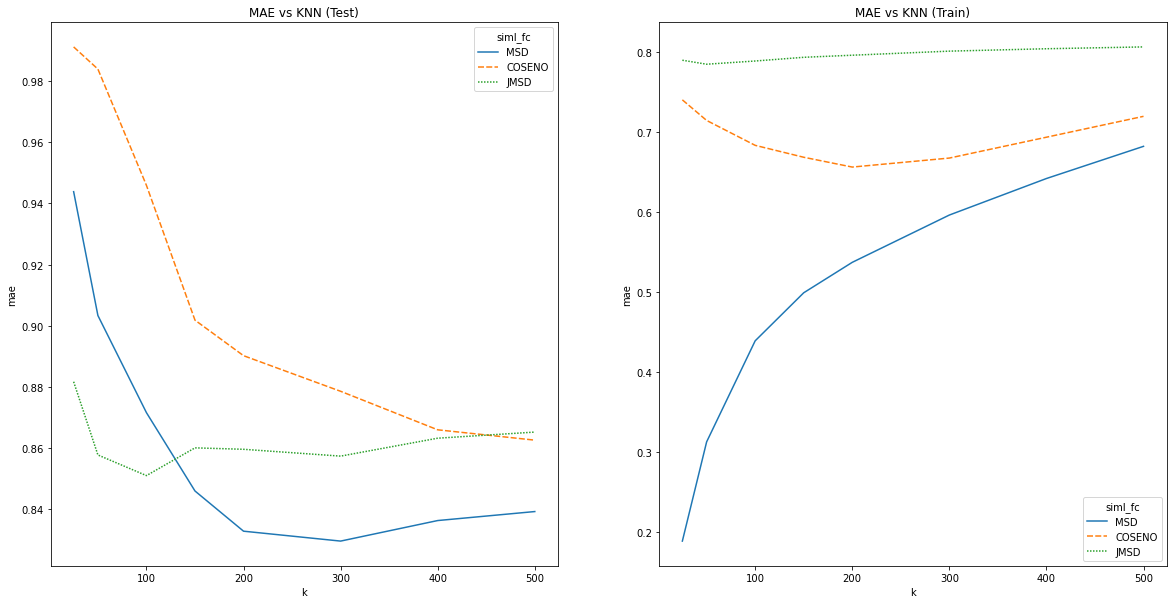

In [19]:
data_test=experiment_df[experiment_df['tipo_mae']=='Test']
data_train=experiment_df[experiment_df['tipo_mae']=='Train']


plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('MAE vs KNN (Test)')
sns.lineplot(data=data_test, x='k',y='mae',hue='siml_fc',style='siml_fc')
plt.subplot(1,2,2)
plt.title('MAE vs KNN (Train)')
sns.lineplot(data=data_train, x='k',y='mae',hue='siml_fc',style='siml_fc')

plt.show()

* Results for test data

In [20]:
pd.pivot_table(data_test,values=['mae'], index=['k'],columns=['siml_fc'])

mae                    
siml_fc    COSENO      JMSD       MSD
k                                    
25       0.991211  0.881689  0.943860
50       0.983949  0.857734  0.903342
100      0.945913  0.850982  0.871570
150      0.901831  0.860059  0.845946
200      0.890210  0.859590  0.832801
300      0.878561  0.857354  0.829561
400      0.865961  0.863219  0.836281
500      0.862582  0.865219  0.839224